In [1]:
from fastai.tabular.all import *

In [2]:
# https://towardsdatascience.com/normalization-vs-standardization-cb8fe15082eb
def normalise(x):
    return (x-min(x))/(max(x)-min(x))

In [3]:
def preprocess(df):
    # Fill missing values with zeroes
    df = df.fillna(value=0)
    # Clip outliers in scoring inputs to provide a better range to the regression
    df['actor_comments_count'].clip(upper=10, inplace=True)
    df['actor_comments_body_count'].clip(upper=500, inplace=True)
    return df

In [4]:
df = pd.read_csv('../storage/results.csv', index_col='item_url')

In [5]:
df = preprocess(df)

In [6]:
# Preview raw data
df.head()

,item_id,item_url,org_id,repo_id,actor_login,type,created_at,is_at_mentioned,title_chars_count,body_chars_count,...,prev_repo_creator_events_count,prev_repo_actor_events_count,all_at_mentions,all_actors,events_count,comments_count,comments_body_count,at_mentions_count,actor_at_mentions_count,actor_comments_body_count
0,53209108,silverstripe/silverstripe-framework/issues/3749,379348.0,1318892,tractorcow,IssuesEvent,2015-01-01 00:04:56 UTC,False,58,619.0,...,0,0,",@jonom,,,,@sb-relaxt-at,,","sb-relaxt-at,sb-relaxt-at,chillu,tractorcow,chillu,jonom,tractorcow,tractorcow",8,6,3192.0,2.0,0,1161.0
1,53245608,silverstripe/silverstripe-cms/issues/1147,379348.0,1319183,jand000,IssuesEvent,2015-01-02 10:15:55 UTC,False,59,323.0,...,0,0,",,,@kinglozzer,,,@jand000,@chillu,@dhensby,@willmorgan,,","jand000,chillu,sminnee,jand000,tractorcow,dhensby,kinglozzer,chillu,tractorcow,dhensby",10,8,5689.0,5.0,1,1810.0
2,26774248,silverstripe/silverstripe-translatable/pulls/178,379348.0,1540453,dhensby,PullRequestEvent,2015-01-02 22:44:24 UTC,False,20,50.0,...,0,0,",","dhensby,chillu",2,0,101.0,0.0,0,50.0
3,26784769,silverstripe/silverstripe-mssql/pulls/20,379348.0,1236917,dhensby,PullRequestEvent,2015-01-03 17:17:47 UTC,False,20,0.0,...,0,0,",","chillu,dhensby",2,0,1.0,0.0,0,0.0
4,26785071,silverstripe-labs/silverstripe-staticpublisher/pulls/41,568043.0,5898270,dhensby,PullRequestEvent,2015-01-03 17:44:57 UTC,False,20,0.0,...,0,0,",","wilr,dhensby",2,0,1.0,0.0,0,0.0


In [6]:
# Preview some values used for scoring
scoring = {
    'actor_events_count': 1, 
    'actor_comments_count': 2, 
    'prev_repo_actor_events_count': 1,
    'actor_comments_body_count': 2
}
scoring_fields = list(scoring.keys())
df[['item_url'] + scoring_fields].sort_values(by=scoring_fields[0], ascending=False).head()

,item_url,actor_events_count,actor_comments_count,prev_repo_actor_events_count,actor_comments_body_count
7229,silverstripe/silverstripe-graphql/pulls/20,42,41,35,5792.0
4607,silverstripe/silverstripe-framework/pulls/5278,31,30,565,11245.0
9227,silverstripe/silverstripe-framework/pulls/7042,30,30,1915,3653.0
13707,silverstripe/silverstripe-framework/pulls/8086,29,29,2413,8126.0
7750,silverstripe/silverstripe-framework/pulls/6607,26,25,1418,5996.0


<AxesSubplot:>

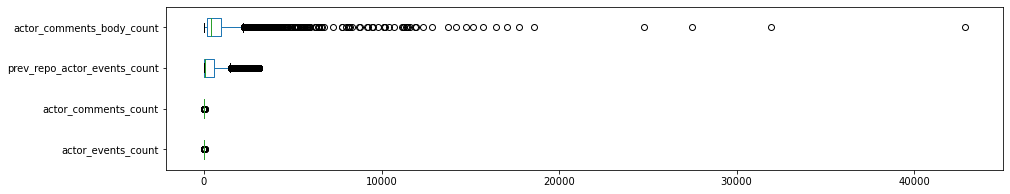

In [7]:
# Explore data distribution to get intuition on scoring
df[scoring_fields].where(df[scoring_fields] > 0).plot.box(vert=False,figsize=(15,3))

<AxesSubplot:>

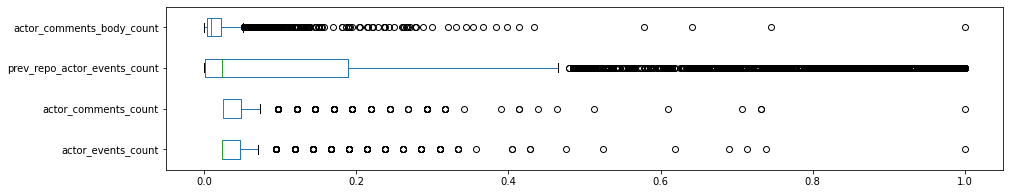

In [42]:
# Naive min-max normalisation to avoid one feature overly influencing the scoring
df[scoring_fields] = df[scoring_fields].apply(normalise)
df[scoring_fields].where(df[scoring_fields] > 0).plot.box(vert=False,figsize=(15,3))

In [34]:
# Calculate score with different weights
# TODO Use apply() and add()
scoring_weights = list(scoring.values())
df['score'] = normalise(
    df[scoring_fields[0]] * scoring_weights[0]
    + df[scoring_fields[1]] * scoring_weights[1]
    + df[scoring_fields[2]] * scoring_weights[2]
    + df[scoring_fields[3]] * scoring_weights[3]
)
# TODO Fix accuracy
#df['score'] = df['score'].apply(lambda x: 1 if x > 0 else 0)
df[['item_url'] + scoring_fields + ['score']].sort_values(by='score', ascending=False).head()

,item_url,actor_events_count,actor_comments_count,prev_repo_actor_events_count,actor_comments_body_count,score
7229,silverstripe/silverstripe-graphql/pulls/20,1.000000,1.000000,0.011196,0.135135,1.000000
13707,silverstripe/silverstripe-framework/pulls/8086,0.690476,0.707317,0.771913,0.189590,0.992301
9227,silverstripe/silverstripe-framework/pulls/7042,0.714286,0.731707,0.612604,0.085229,0.902268
6859,silverstripe/silverstripe-framework/issues/6245,0.214286,0.170732,0.400512,1.000000,0.900897
4607,silverstripe/silverstripe-framework/pulls/5278,0.738095,0.731707,0.180742,0.262360,0.885876


In [25]:
# Don't include scoring_fields in here since that would be cheating
dep_var = 'score'
cat_names = [
  'org_id',
  'repo_id',
  'actor_login',
  'type',
  'is_at_mentioned',
  # TODO Destructure multi-value fields  
  #'all_actors',
  #'all_at_mentions',
]
cont_names = [
  'title_chars_count',
  'body_chars_count',
  'markdown_chars_count',
  'prev_repo_creator_events_count',
  'events_count',
  'comments_count',
  'comments_body_count',
  'actor_at_mentions_count',
  'at_mentions_count',
]
procs = [
  FillMissing,
  Categorify,
  Normalize
]

In [35]:
# Create fast.ai (PyTorch) data set
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
dls = (TabularPandas(
    df,
    cat_names=cat_names,
    cont_names=cont_names,
    procs=procs,
    y_names='score',
    # TODO Fix accuracy
    #y_block=CategoryBlock,
    splits=splits
)).dataloaders(bs=64)

In [36]:
learn = tabular_learner(dls, metrics=accuracy)

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.0005754399462603033)

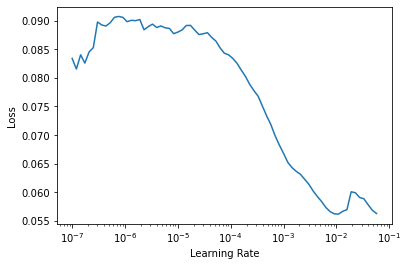

In [37]:
# Intuit the learning rate
learn.lr_find()

In [38]:
learn.fine_tune(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.003324,0.002595,0.127674,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.002171,0.002100,0.127674,00:06
1,0.001451,0.001556,0.127674,00:06


In [39]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.001285,0.001403,0.127674,00:06


In [40]:
learn.show_results()

,org_id,repo_id,actor_login,type,is_at_mentioned,title_chars_count,body_chars_count,markdown_chars_count,prev_repo_creator_events_count,events_count,comments_count,comments_body_count,actor_at_mentions_count,at_mentions_count,score,score_pred
0,4.0,20.0,132.0,1.0,1.0,0.751629,1.365931,-0.208142,-0.320206,3.211831,3.242688,1.992457,-0.117526,1.262059,0.101971,0.168433
1,4.0,118.0,967.0,1.0,1.0,-0.216954,-0.057126,-0.069079,-0.319295,0.790837,0.783528,0.241784,-0.117526,1.780085,0.002730,0.002791
2,4.0,104.0,487.0,2.0,1.0,-0.798105,-0.316854,-0.208142,-0.018862,-0.419661,-0.446052,-0.337873,-0.117526,-0.292018,0.012186,0.011526
3,4.0,133.0,942.0,1.0,1.0,0.654771,-0.256009,0.069984,-0.319295,-0.419661,-0.241122,-0.331143,-0.117526,0.226008,0.000000,0.000163
4,2.0,4.0,1105.0,2.0,1.0,-0.120096,-0.241478,-0.208142,-0.248284,-0.419661,-0.446052,-0.311831,-0.117526,-0.292018,0.000292,0.001489
5,6.0,60.0,550.0,2.0,1.0,-0.604388,-0.184265,-0.208142,-0.317475,-0.621410,-0.446052,-0.345480,-0.117526,-0.292018,0.000195,-0.001557
6,4.0,74.0,310.0,2.0,1.0,1.139063,-0.308681,-0.208142,-0.318385,-0.419661,-0.446052,-0.355136,-0.117526,-0.292018,0.000195,0.001972
7,16.0,30.0,308.0,1.0,1.0,-0.943392,-0.154297,-0.208142,-0.317475,1.396085,1.603248,0.328103,-0.117526,-0.292018,0.000000,0.000469
8,4.0,21.0,780.0,1.0,1.0,0.557913,-0.223316,-0.208142,-0.291983,-0.016162,0.168738,-0.315634,-0.117526,0.226008,0.063074,0.048714
